# Hop Teaming Analysis - Exploration of Data

## Team: The Hindenburgs

![The Hindenburgs](../img/the_hindenburgs_propaganda.png)

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

The four tables contained within 'hop_teaming_database.sqlite' are:

- hop_teaming
- nnpes
- nucc_taxonomy
- zip_cbsa
- tn_hospital_info
- facility_affiliation

## Exploratory Data Analysis

The starting point (below) is to find out all of the hospitals in the Nashville area. We do that by selecting the entity type 2 (Hospitals, Urgent Care, Doctors Offices) and TN as state from NNPES data. Further, select classifications that end in Hospital from the taxonomy table (ensuring just Hospitals and nothing else) and cbsa for Nashville and surrounding area.

**Important**:
- We tested the code with different res_ratio and found out that setting it anywhere from >= 0.1 to >= 0.75, the end result is the same
- Importantly, by using **any** kind of cut on res_ratio, we lose lots of important referrals (to the point where it knocks down Vanderbilt from #1 on the list to about #6 or #7), so we decided against that

That brings us to 141 total npis

> NOTE: there are 32 entity_type_codes 2.0 in Nashville that have no primary taxonomy

> NOTE2: during first attempt we used `address_city_name = 'NASHVILLE'` however, that excludes hospitals located in Madison, Franklin or similar. that is the reason to use CBSA instead, as well as res_ratio that tells how much of a ZIP code is included within a given CBSA

In [2]:
query = """
SELECT DISTINCT npi, organization_name
FROM nnpes AS np
INNER JOIN nucc_taxonomy AS nt
ON np.primary_taxonomy = nt.code
INNER JOIN zip_cbsa AS zc
ON np.address_postal_code = zc.zip
WHERE entity_type_code = 2.0
    AND address_state_name = 'TN'
    AND classification LIKE '%Hospital'
    AND cbsa = 34980
    --AND res_ratio >= 0.5
"""

with sqlite3.connect('../data/hop_teaming_database.sqlite') as db: 
    hospitals = pd.read_sql(query, db)

# hospitals

# hospitals['organization_name'].nunique()

In [3]:
var = tuple(hospitals['npi'].tolist())

query =f"""
SELECT DISTINCT organization_name
FROM hop_teaming ht
INNER JOIN nnpes np
ON ht.to_npi = np.npi
WHERE to_npi IN {var}
"""

with sqlite3.connect('../data/hop_teaming_database.sqlite') as db: 
    hop_hospitals = pd.read_sql(query, db)

hop_hospitals

,organization_name
0,SAINT THOMAS WEST HOSPITAL
1,"HCA HEALTH SERVICES OF TENNESSEE, INC."
2,VANDERBILT UNIVERSITY MEDICAL CENTER
3,MAURY REGIONAL HOSPITAL
4,"SAINT THOMAS STONES RIVER HOSPITAL, LLC"
5,"SAINT THOMAS RIVER PARK HOSPITAL, LLC"
6,RIVERVIEW MEDICAL CENTER LLC
7,NASHVILLE GENERAL HOSPITAL
8,SAINT THOMAS RUTHERFORD HOSPITAL
9,SUMNER REGIONAL MEDICAL CENTER LLC


Using the constructed query from above, we then select data (matching on to_npi) from hop_teaming dataset that match the NPIs of hospitals.

In [4]:
query = """
WITH hospitals AS (
    SELECT DISTINCT npi
    FROM nnpes AS np
    INNER JOIN nucc_taxonomy AS nt
    ON np.primary_taxonomy = nt.code
    INNER JOIN zip_cbsa AS zc
    ON np.address_postal_code = zc.zip
    WHERE entity_type_code = 2.0
        AND address_state_name = 'TN'
        AND cbsa = 34980
        --AND res_ratio >= 0.5
        AND classification LIKE '%Hospital'
)
SELECT
    from_npi,
    to_npi,
    SUM(patient_count) AS patient_total,
    SUM(transaction_count) AS transaction_total
FROM hop_teaming
WHERE to_npi IN hospitals
GROUP BY from_npi, to_npi
"""

# number of places that refer to major hospitals 14031
# number of unique places that refer to hospitals 7688

with sqlite3.connect('../data/hop_teaming_database.sqlite') as db: 
    providers_to_hospitals = pd.read_sql(query, db)

providers_to_hospitals

,from_npi,to_npi,patient_total,transaction_total
0,1003013160,1629025648,33,51
1,1003013947,1023055126,99,279
2,1003019902,1396882205,215,339
3,1003019902,1558408633,56,62
4,1003028770,1861479545,1905,2649
...,...,...,...,...
14031,1992972087,1720032345,200,346
14032,1992985055,1942442710,122,164
14033,1992985055,1992776405,71,113
14034,1992985949,1023055126,277,767


Checking out the providers_to_hospitals only 25% of the value pairs from the table share more than 200 patients (in given year) between them.

> note: number of places that refer to hospitals is 14031; number of unique places that refer to hospitals is 7688

In [5]:
# providers_to_hospitals.sort_values('patient_total', ascending=False)
# providers_to_hospitals.sort_values('transaction_total', ascending=False)
providers_to_hospitals.describe()

,from_npi,to_npi,patient_total,transaction_total
count,1.403600e+04,1.403600e+04,14036.000000,14036.000000
mean,1.494109e+09,1.507474e+09,241.426973,399.899117
std,2.882206e+08,2.733370e+08,786.736577,2309.469018
min,1.003013e+09,1.023055e+09,11.000000,50.000000
25%,1.245325e+09,1.396882e+09,57.000000,77.000000
50%,1.487935e+09,1.396882e+09,100.000000,138.000000
75%,1.740277e+09,1.780779e+09,215.000000,319.000000
max,1.992987e+09,1.992861e+09,62104.000000,223846.000000


## Major hospitals based on patients

- First, build a profile of providers referring patients to the major hospitals in Nashville. Are certain specialties more likely to refer to a particular hospital over the others?

Comact code below, with the added grouping of major hospital groups:

In [8]:
query = '''
WITH provider_referrals AS (
SELECT 
    n1.npi,
    t1.specialization
FROM nnpes n1
INNER JOIN nucc_taxonomy as t1
ON n1.primary_taxonomy = t1.code
WHERE n1.entity_type_code = 1
    AND t1.specialization <> 'None'
),
major_hospitals AS (
SELECT
    n2.npi,
    n2.organization_name,
    CASE
        WHEN organization_name = 'VANDERBILT UNIVERSITY MEDICAL CENTER'
            OR organization_name = 'SHELBYVILLE HOSPITAL COMPANY LLC'
            THEN 'Vanderbilt'
        WHEN organization_name = 'HCA HEALTH SERVICES OF TENNESSEE, INC.'
            OR organization_name = 'HTI MEMORIAL HOSPITAL CORPORATION'
            OR organization_name = 'HENDERSONVILLE HOSPITAL CORPORATION'
            OR organization_name = 'CENTRAL TENNESSEE HOSPITAL CORPORATION'
            OR organization_name = 'NORTHCREST MEDICAL CENTER'
            THEN 'HCA Healthcare'
        WHEN organization_name = 'SAINT THOMAS WEST HOSPITAL'
            OR organization_name = 'SAINT THOMAS RUTHERFORD HOSPITAL'
            OR organization_name = 'SAINT THOMAS RIVER PARK HOSPITAL, LLC'
            OR organization_name = 'SAINT THOMAS DEKALB HOSPITAL, LLC'
            OR organization_name = 'SAINT THOMAS STONES RIVER HOSPITAL, LLC'
            OR organization_name = 'RIVER PARK HOSPITAL LLC'
            THEN 'Ascension'
        WHEN organization_name = 'MAURY REGIONAL HOSPITAL'
            OR organization_name = 'MAURY REGIONAL HOSPITAL MARSHALL MEDICAL CENTER'
            THEN 'Maury Regional Medical Group'
        WHEN organization_name = 'WILLIAMSON COUNTY HOSPITAL DISTRICT'
            THEN 'Williamson Medical Group'
        WHEN organization_name = 'SUMNER REGIONAL MEDICAL CENTER LLC'
            OR organization_name = 'RIVERVIEW MEDICAL CENTER LLC'
            OR organization_name = 'SUMNER REGIONAL HEALTH SYSTEMS, INC'
            OR organization_name = 'TROUSDALE MEDICAL CENTER LLC'
            OR organization_name = 'SRHS HOLDINGS LLC'
            THEN 'High Point Health System'
        ELSE 'other'
    END AS parent_org    
FROM nnpes n2
INNER JOIN nucc_taxonomy as t2
ON n2.primary_taxonomy = t2.code
INNER JOIN zip_cbsa as zc
ON n2.address_postal_code = zc.zip
WHERE n2.address_state_name = 'TN'
    AND n2.entity_type_code = 2
    AND t2.classification LIKE '%Hospital'
    AND zc.cbsa = 34980
)
SELECT
    pr.npi AS from_npi,
    pr.specialization,
    mh.parent_org, 
    SUM(hop.transaction_count) AS total_transactions,
    SUM(hop.patient_count) AS total_patients
FROM hop_teaming AS hop
INNER JOIN provider_referrals pr
ON hop.from_npi = pr.npi
INNER JOIN major_hospitals mh
ON hop.to_npi = mh.npi 
GROUP BY pr.npi, pr.specialization, mh.parent_org
ORDER BY total_patients DESC;
'''

with sqlite3.connect('../data/hop_teaming_database.sqlite') as db: 
    providers_to_major = pd.read_sql(query, db)

providers_to_major

,from_npi,specialization,parent_org,total_transactions,total_patients
0,1093753303,Anatomic Pathology & Clinical Pathology,HCA Healthcare,26785,15029
1,1417131715,Interventional Cardiology,HCA Healthcare,9912,6360
2,1912984758,Diagnostic Radiology,HCA Healthcare,5050,4648
3,1871548818,Diagnostic Radiology,HCA Healthcare,5124,4547
4,1134321235,Diagnostic Radiology,Ascension,5713,4526
...,...,...,...,...,...
3547,1801301999,Acute Care,Vanderbilt,58,17
3548,1861571168,Clinical,Vanderbilt,50,17
3549,1104808641,Nephrology,Vanderbilt,57,16
3550,1144287772,Psychiatry,Maury Regional Medical Group,102,14


In [9]:
special_referrals = (
    providers_to_major
        .drop(columns='from_npi')
        .groupby(['specialization','parent_org'])
        .sum(['total_transactions', 'total_patients'])
        .sort_values(['specialization', 'total_patients'], ascending=[True,False])
        .reset_index()
)

In [10]:
special_referrals['patients_ratio'] = (
    special_referrals['total_patients'] / special_referrals.groupby('specialization')['total_patients'].transform('sum')
)

In [11]:
# check how many different specializations each parent_org has

(
special_referrals
    .loc[special_referrals
        .groupby(['specialization'])['patients_ratio']
        .transform(max) == special_referrals['patients_ratio']]
    .sort_values('patients_ratio', ascending = False)
)

,specialization,parent_org,total_transactions,total_patients,patients_ratio
310,"Psychiatric/Mental Health, Adult",Vanderbilt,53,47,1.000000
78,Clinical Genetics (M.D.),Vanderbilt,66,53,1.000000
251,Obstetrics,Maury Regional Medical Group,134,94,1.000000
82,Corneal and Contact Management,Vanderbilt,93,71,1.000000
83,Counseling,Ascension,91,55,1.000000
...,...,...,...,...,...
318,Pulmonary Disease,HCA Healthcare,28458,11540,0.332191
224,Nephrology,Vanderbilt,20436,10324,0.312564
114,Family,Vanderbilt,25172,17454,0.295961
138,Gastroenterology,Vanderbilt,11407,7869,0.293773


Which hospital is referred to the most by certain specializations?

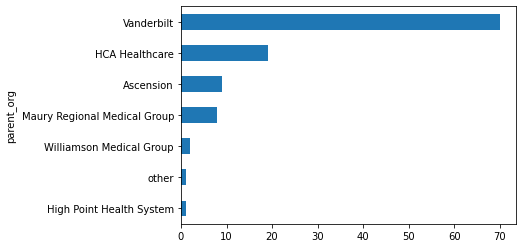

In [12]:
(
special_referrals
    .loc[special_referrals
        .groupby(['specialization'])['patients_ratio']
        .transform(max) == special_referrals['patients_ratio']]
    .sort_values('patients_ratio', ascending = False)
    .groupby('parent_org')['specialization']
    .count()
    .sort_values()
    .plot(kind='barh')
);

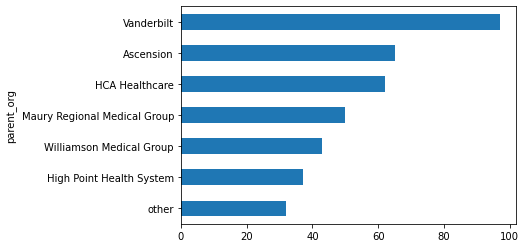

In [13]:
special_referrals.groupby('parent_org')['specialization'].count().sort_values().plot(kind='barh');

* Determine which professionals Vanderbilt Hospital should reach out to in the Nashville area to expand their own patient volume. 
    - First, research which professionals are sending significant numbers of patients only to competitor hospitals (such as TriStar Centennial Medical Center).

Our first approach was to find all npis that do not have a single referral to Vanderbilt. Since most (all?) accidental referrals were eliminated by using transaction_count is at least 50 and the average_day_wait is less than 50, then this approach made sense.

In [14]:
(
    providers_to_major
    .loc[~providers_to_major['from_npi']
            .isin(providers_to_major
                .loc[providers_to_major['parent_org'] == 'Vanderbilt']
                ['from_npi']
                .unique())]
)

,from_npi,specialization,parent_org,total_transactions,total_patients
1,1417131715,Interventional Cardiology,HCA Healthcare,9912,6360
2,1912984758,Diagnostic Radiology,HCA Healthcare,5050,4648
3,1871548818,Diagnostic Radiology,HCA Healthcare,5124,4547
5,1306993282,Diagnostic Radiology,HCA Healthcare,4706,4266
7,1376756742,Diagnostic Radiology,HCA Healthcare,4508,4023
...,...,...,...,...,...
3531,1003819277,Cardiovascular Disease,Williamson Medical Group,52,23
3538,1881934610,Family,Ascension,57,22
3539,1245325661,Interventional Cardiology,Williamson Medical Group,52,21
3550,1144287772,Psychiatry,Maury Regional Medical Group,102,14


In [15]:
providers_to_major.groupby('parent_org')['total_patients'].sum()

parent_org
Ascension                       231132
HCA Healthcare                  347150
High Point Health System         46997
Maury Regional Medical Group     99381
Vanderbilt                      344977
Williamson Medical Group         47434
other                            18701
Name: total_patients, dtype: int64

There are 1194 providers who don't refer to Vanderbilt.

- Next, consider the specialty of the provider. If Vanderbilt wants to increase volume from Orthopedic Surgeons or from Family Medicine doctors who should they reach out to in those areas?

In [16]:
(
    providers_to_major
    .loc[~providers_to_major['from_npi']
            .isin(providers_to_major
                .loc[providers_to_major['parent_org'] == 'Vanderbilt']
                ['from_npi']
                .unique())]
    .groupby('specialization')
    ['from_npi']
    .nunique()
    .sort_values(ascending=False)
)

specialization
Family                                                      270
Diagnostic Radiology                                        129
Cardiovascular Disease                                       64
Acute Care                                                   59
Pulmonary Disease                                            54
                                                           ... 
Oral and Maxillofacial Surgery                                1
Orthopedic                                                    1
Otology & Neurotology                                         1
Pediatric Cardiology                                          1
Neurology with Special Qualifications in Child Neurology      1
Name: from_npi, Length: 80, dtype: int64

In [17]:
(
    providers_to_major
    .loc[~providers_to_major['from_npi']
            .isin(providers_to_major
                .loc[providers_to_major['parent_org'] == 'Vanderbilt']
                ['from_npi']
                .unique())]
    .groupby('specialization')
    [['total_transactions', 'total_patients']]
    .sum()
    .sort_values(by='total_patients', ascending=False)
)

,total_transactions,total_patients
specialization,,
Diagnostic Radiology,241454,217066
Cardiovascular Disease,92913,62825
Family,56882,37053
Pulmonary Disease,49628,23992
Anatomic Pathology & Clinical Pathology,24944,23562
...,...,...
Orthopedic,60,47
Medical-Surgical,169,46
Oral and Maxillofacial Surgery,60,38


Alternatively below, trying to find out any small number of referrals (proportionately, instead of just being 0).

In [18]:
providers_to_major.groupby(['from_npi', 'specialization', 'parent_org'])['total_patients'].sum().reset_index().pivot_table(values='total_patients', index=['from_npi','specialization'], columns='parent_org')

,parent_org,Ascension,HCA Healthcare,High Point Health System,Maury Regional Medical Group,Vanderbilt,Williamson Medical Group,other
from_npi,specialization,,,,,,,
1003019902,Neurology,NaN,NaN,NaN,NaN,271.0,NaN,NaN
1003031261,Hand Surgery,NaN,93.0,NaN,NaN,NaN,NaN,NaN
1003050972,Pulmonary Disease,NaN,NaN,NaN,NaN,190.0,NaN,NaN
1003098963,Psychiatric/Mental Health,NaN,NaN,NaN,NaN,28.0,NaN,NaN
1003112277,Family,70.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1992897326,Nephrology,NaN,NaN,NaN,NaN,439.0,29.0,NaN
1992902738,Acute Care,NaN,NaN,NaN,NaN,64.0,NaN,NaN
1992904049,Neurology,NaN,NaN,NaN,NaN,106.0,NaN,NaN


In [19]:
providers_to_major.groupby(['specialization', 'parent_org'])['total_patients'].sum().reset_index().pivot_table(values='total_patients', index='specialization', columns='parent_org')

parent_org,Ascension,HCA Healthcare,High Point Health System,Maury Regional Medical Group,Vanderbilt,Williamson Medical Group,other
specialization,,,,,,,
Acute Care,4934.0,4566.0,228.0,763.0,13753.0,40.0,53.0
Addiction Medicine,84.0,81.0,NaN,NaN,128.0,NaN,90.0
Addiction Psychiatry,NaN,NaN,NaN,NaN,89.0,NaN,NaN
Adolescent Medicine,48.0,30.0,NaN,224.0,68.0,NaN,NaN
Adult Congenital Heart Disease,NaN,NaN,NaN,NaN,70.0,NaN,NaN
...,...,...,...,...,...,...,...
Trauma Surgery,NaN,760.0,NaN,NaN,2254.0,NaN,NaN
Vascular & Interventional Radiology,1913.0,5153.0,NaN,NaN,1294.0,NaN,NaN
Vascular Neurology,489.0,NaN,NaN,NaN,411.0,NaN,NaN


## Community Detection

* Finally, look for "communities" of providers in the Nashville/Davidson County CBSA. Make use of the Louvain community detection algorithm from Neo4j: https://neo4j.com/docs/graph-data-science/current/algorithms/louvain/.

In [20]:
query = """
SELECT
    from_npi,
    to_npi,
    transaction_count,
    patient_count
FROM hop_teaming AS hop
INNER JOIN nnpes AS n1
ON hop.from_npi = n1.npi
INNER JOIN zip_cbsa AS zc1
ON n1.address_postal_code = zc1.zip
INNER JOIN nnpes AS n2
ON hop.to_npi = n2.npi
INNER JOIN zip_cbsa AS zc2
ON n2.address_postal_code = zc2.zip
WHERE n1.address_state_name = 'TN'
    AND n2.address_state_name = 'TN'
    AND zc1.cbsa = 34980
    AND zc2.cbsa = 34980
"""

with sqlite3.connect('../data/hop_teaming_database.sqlite') as db: 
    hops_discovery = pd.read_sql(query, db)

hops_discovery

,from_npi,to_npi,transaction_count,patient_count
0,1922001957,1578584199,148,129
1,1013910892,1790983104,139,133
2,1013910892,1811987050,53,53
3,1154324192,1578584199,206,202
4,1235132408,1093741464,133,112
...,...,...,...,...
158268,1104850130,1649228735,75,52
158269,1104850130,1700878360,122,85
158270,1104850130,1811955917,93,59
158271,1104850130,1861479545,307,217


In [21]:
hops_discovery.to_csv('../data/hops_discovery.csv')

What I did in neo4j:
- create database hopsdiscovery
- use hopsdiscovery
- CREATE CONSTRAINT FOR (p:Provider) REQUIRE p.name IS UNIQUE;
- open terminal from neo4j and then "open ." to open finder there and copy the .csv file into import

And then run this code:
```
LOAD CSV WITH HEADERS
FROM 'file:///hops_discovery.csv' AS line
WITH line

MERGE (from:Provider {name: line.from_npi})
MERGE (to:Provider {name: line.to_npi})

CREATE (from)-[:REFERRED {transaction_count: toInteger(line.transaction_count)}]->(to);
```

> Can also do something like this to show graph (note: it will only display 300 nodes since there's way more):
```
MATCH (:Provider)-[:REFERRED]->(p:Provider)
RETURN p
```

Next, run thnis script to prep the algorithm:
```
CALL gds.graph.project( 
    'hopsdiscovery',
    'Provider',
    {
        REFERRED: {
        orientation: 'UNDIRECTED', aggregation: 'SUM'
        }
    },
    {
        relationshipProperties: 'transaction_count'
    }
)
```

And then call algorithm on graph (and save as .csv):
```
CALL gds.louvain.stream('hopsdiscovery', { relationshipWeightProperty: 'transaction_count' }) YIELD nodeId, communityId
RETURN gds.util.asNode(nodeId).name AS name, communityId
ORDER BY name ASC
```

Results imported below!

In [22]:
louvain_community = pd.read_csv('../data/louvain_community.csv')

In [23]:
louvain_bua = pd.read_csv('../data/louvain.csv')

In [ ]:
# fig, axes = plt.subplots(2, sharex=True, figsize=(10, 10))
# axes = axes.flatten()
# fig.suptitle('Community Detection')

# ax = louvain_community.groupby('communityId').count().nlargest(20, columns='name').plot(kind='barh', ax=axes[0])
# ax = louvain_bua.groupby('communityId').count().nlargest(20, columns='name').plot(kind='barh', ax=axes[1])

# fig = ax.get_figure()
# fig.tight_layout()
# fig.subplots_adjust(top=0.95)

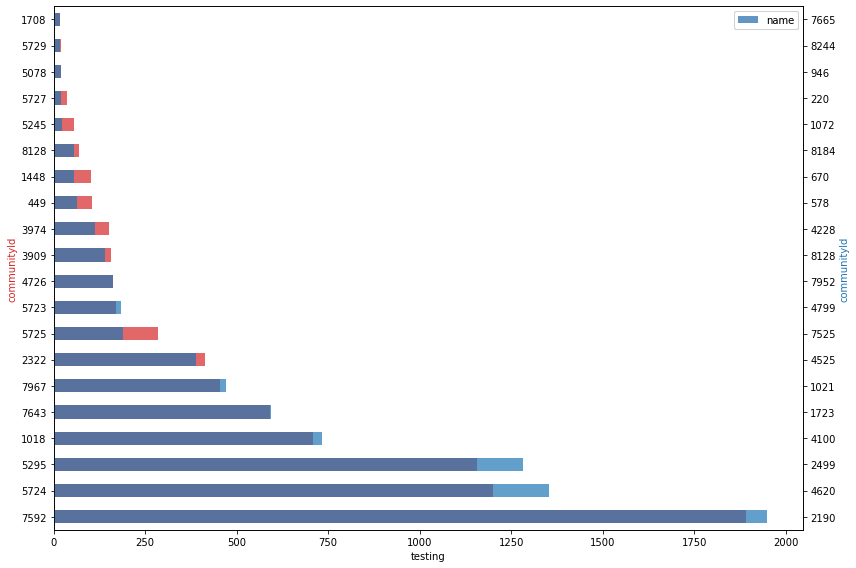

In [24]:
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:red'
ax1.set_xlabel('testing')
ax1.set_ylabel('community ID', color=color)
louvain_community.groupby('communityId').count().nlargest(20, columns='name').plot(kind='barh', alpha=0.7, color=color, ax=ax1)
#ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('more testing', color=color)  # we already handled the x-label with ax1
louvain_bua.groupby('communityId').count().nlargest(20, columns='name').plot(kind='barh', alpha=0.7, color=color, ax=ax2)
#ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Finding out how many communities to use:

`louvain_community['name'].count()`

There are 8308 NPIs

And using 

`hops_discovery['transaction_count'].sum()`

There are 45463255 total referrals (within greater Nashville Area)

Using the two next lines of code and changing how many of the top groups I take, here's the result, indicating the % of total NPIs and % of total referrals that are contained within that group.

| Metric          | Top 1   | Top 2   | Top 3   | Top 4   | Top 5   | Top 6   |
| --------------- | ------- | ------- | ------- | ------- | ------- | ------- |
| % of NPIs       | 22.76%  | 37.21%  | 51.12%  | 59.65%  | 66.78%  | 72.23%  |
| % of Ref from   | 13.40%  | 37.08%  | 54.74%  | 61.30%  | 68.15%  | 80.85%  |
| % of Ref to     | 13.66%  | 37.06%  | 54.76%  | 61.27%  | 68.07%  | 80.46%  |

In [69]:
# for cumulative
# louvain_community.groupby('communityId').count().sort_values(by='name', ascending=False).head(6).sum() / 8308

# for individual
louvain_community.groupby('communityId').count().sort_values(by='name', ascending=False).iloc[[4]].sum() / 8308

name    0.071257
dtype: float64

In [44]:
hops_discovery.loc[hops_discovery['from_npi'].isin(louvain_community.loc[louvain_community['communityId'].isin([7592,5724,5295,1018,7643,7967])]['name'])]['transaction_count'].sum()/hops_discovery['transaction_count'].sum()

0.8084990175032563

In [55]:
hops_discovery.loc[hops_discovery['to_npi'].isin(louvain_community.loc[louvain_community['communityId'].isin([7592,5724,5295,1018,7643,7967])]['name'])]['transaction_count'].sum()/hops_discovery['transaction_count'].sum()

0.8046182131041871

There are 8308 distinct NPIs

In [70]:
first_group = tuple(louvain_community.loc[louvain_community['communityId'] == 7592]['name'].tolist())
second_group = tuple(louvain_community.loc[louvain_community['communityId'] == 5724]['name'].tolist())
third_group = tuple(louvain_community.loc[louvain_community['communityId'] == 5295]['name'].tolist())
fourh_group = tuple(louvain_community.loc[louvain_community['communityId'] == 1018]['name'].tolist())
fifth_group = tuple(louvain_community.loc[louvain_community['communityId'] == 7643]['name'].tolist())
sixth_group = tuple(louvain_community.loc[louvain_community['communityId'] == 7967]['name'].tolist())
seventh_group = tuple(louvain_community.loc[louvain_community['communityId'] == 2322]['name'].tolist())
eigth_group = tuple(louvain_community.loc[louvain_community['communityId'] == 5725]['name'].tolist())
nineth_group = tuple(louvain_community.loc[louvain_community['communityId'] == 5723]['name'].tolist())
tenth_group = tuple(louvain_community.loc[louvain_community['communityId'] == 4726]['name'].tolist())
eleventh_group = tuple(louvain_community.loc[louvain_community['communityId'] == 3909]['name'].tolist())
twelfth_group = tuple(louvain_community.loc[louvain_community['communityId'] == 3974]['name'].tolist())
top_groups = first_group + second_group + third_group + fourh_group + fifth_group  + sixth_group + seventh_group + eigth_group + nineth_group + tenth_group + eleventh_group + twelfth_group



query =f"""
SELECT
    *,
    CASE
        WHEN organization_name = 'VANDERBILT UNIVERSITY MEDICAL CENTER'
            OR organization_name = 'SHELBYVILLE HOSPITAL COMPANY LLC'
            THEN 'Vanderbilt'
        WHEN organization_name = 'HCA HEALTH SERVICES OF TENNESSEE, INC.'
            OR organization_name = 'HTI MEMORIAL HOSPITAL CORPORATION'
            OR organization_name = 'HENDERSONVILLE HOSPITAL CORPORATION'
            OR organization_name = 'CENTRAL TENNESSEE HOSPITAL CORPORATION'
            OR organization_name = 'NORTHCREST MEDICAL CENTER'
            THEN 'HCA Healthcare'
        WHEN organization_name = 'SAINT THOMAS WEST HOSPITAL'
            OR organization_name = 'SAINT THOMAS RUTHERFORD HOSPITAL'
            OR organization_name = 'SAINT THOMAS RIVER PARK HOSPITAL, LLC'
            OR organization_name = 'SAINT THOMAS DEKALB HOSPITAL, LLC'
            OR organization_name = 'SAINT THOMAS STONES RIVER HOSPITAL, LLC'
            OR organization_name = 'RIVER PARK HOSPITAL LLC'
            THEN 'Ascension'
        WHEN organization_name = 'MAURY REGIONAL HOSPITAL'
            OR organization_name = 'MAURY REGIONAL HOSPITAL MARSHALL MEDICAL CENTER'
            THEN 'Maury Regional Medical Group'
        WHEN organization_name = 'WILLIAMSON COUNTY HOSPITAL DISTRICT'
            THEN 'Williamson Medical Group'
        WHEN organization_name = 'SUMNER REGIONAL MEDICAL CENTER LLC'
            OR organization_name = 'RIVERVIEW MEDICAL CENTER LLC'
            OR organization_name = 'SUMNER REGIONAL HEALTH SYSTEMS, INC'
            OR organization_name = 'TROUSDALE MEDICAL CENTER LLC'
            OR organization_name = 'SRHS HOLDINGS LLC'
            THEN 'High Point Health System'
        ELSE 'other'
    END AS parent_org,
    CASE
        WHEN npi in {first_group} THEN 1
        WHEN npi in {second_group} THEN 2
        WHEN npi in {third_group} THEN 3
        WHEN npi in {fourh_group} THEN 4
        WHEN npi in {fifth_group} THEN 5
        WHEN npi in {sixth_group} THEN 6
        WHEN npi in {seventh_group} THEN 7
        WHEN npi in {eigth_group} THEN 8
        WHEN npi in {nineth_group} THEN 9
        WHEN npi in {tenth_group} THEN 10
        WHEN npi in {eleventh_group} THEN 11
        WHEN npi in {twelfth_group} THEN 12
    END as group_position
FROM nnpes AS np
INNER JOIN nucc_taxonomy as t
ON np.primary_taxonomy = t.code
WHERE npi IN {top_groups}
"""


with sqlite3.connect('../data/hop_teaming_database.sqlite') as db: 
    largest_communities = pd.read_sql(query, db)

#largest_communities

In [71]:
largest_communities.groupby(['group_position','parent_org'])['npi'].count()

group_position  parent_org                  
1               Vanderbilt                         8
                Williamson Medical Group           1
                other                           1880
2               HCA Healthcare                    16
                other                           1183
3               Ascension                         11
                other                           1141
4               Ascension                          4
                other                            705
5               Maury Regional Medical Group       5
                Vanderbilt                         5
                other                            578
6               HCA Healthcare                     1
                other                            449
7               HCA Healthcare                     1
                Vanderbilt                         3
                other                            406
8               High Point Health System           8
 

In [72]:
largest_communities.groupby('group_position')['specialization'].nunique()

group_position
1     98
2     58
3     61
4     62
5     60
6     39
7     39
8     38
9     25
10     3
11    21
12    16
Name: specialization, dtype: int64

In [60]:
#largest_communities.loc[largest_communities['group_position'] == 1].groupby('specialization')['npi'].count().sort_values(ascending=False)
#largest_communities.loc[largest_communities['group_position'] == 2].groupby('specialization')['npi'].count().sort_values(ascending=False)
#largest_communities.loc[largest_communities['group_position'] == 3].groupby('specialization')['npi'].count().sort_values(ascending=False)
#largest_communities.loc[largest_communities['group_position'] == 4].groupby('specialization')['npi'].count().sort_values(ascending=False)
largest_communities.loc[largest_communities['group_position'] == 5].groupby('specialization')['npi'].count().sort_values(ascending=False)

specialization
Family                                                      67
Psychiatric/Mental Health                                   22
Clinical                                                    18
Diagnostic Radiology                                        16
Community/Retail Pharmacy                                   10
Medical                                                     10
Psychiatry                                                   8
Nephrology                                                   7
Primary Care                                                 6
Cardiovascular Disease                                       5
Critical Care Medicine                                       5
Rural Health                                                 5
Surgical                                                     5
Gastroenterology                                             5
Foot & Ankle Surgery                                         5
Foot Surgery                            

## Adding additional 2 datasets

To try and see which additional npis might be affiliated with Vanderbilt.

In [114]:
query = """ 
SELECT *
FROM facility_affiliation
LIMIT 100
"""

with sqlite3.connect('../data/hop_teaming_database.sqlite') as db: 
    testing_communities = pd.read_sql(query, db)

testing_communities

,npi,ind_pac_id,lst_nm,frst_nm,mid_nm,suff,facility_type,facility_afl_ccn,parent_ccn
0,1003000126,7517003643,ENKESHAFI,ARDALAN,None,None,Hospital,210003,None
1,1003000126,7517003643,ENKESHAFI,ARDALAN,None,None,Hospital,210022,None
2,1003000126,7517003643,ENKESHAFI,ARDALAN,None,None,Hospital,490063,None
3,1003000126,7517003643,ENKESHAFI,ARDALAN,None,None,Hospital,490145,None
4,1003000134,4284706367,CIBULL,THOMAS,L,None,Hospital,140010,None
...,...,...,...,...,...,...,...,...,...
95,1003005836,6103979430,LEASURE,EMILY,L,None,Home health agency,248056,None
96,1003006099,2163791153,OSTOJA,ELIZABETH,None,None,Hospital,420068,None
97,1003006115,9335223908,DURHAM,BENJAMIN,W,None,Hospital,010168,None
98,1003006115,9335223908,DURHAM,BENJAMIN,W,None,Hospital,110002,None


In [119]:
npis_in_communities = tuple(louvain_community['name'].tolist())

query =f"""
SELECT *
FROM nnpes AS np
LEFT JOIN facility_affiliation AS fa
USING(npi)
LEFT JOIN tn_hospital_info AS tn
ON fa.facility_afl_ccn = tn.facility_id
WHERE np.npi in {npis_in_communities}
"""


with sqlite3.connect('../data/hop_teaming_database.sqlite') as db: 
    testing_communities = pd.read_sql(query, db)

testing_communities

,npi,entity_type_code,organization_name,last_name,first_name,middle_name,name_prefix_text,name_suffix_text,credential_text,first_line_address,...,count_of_readm_measures_better,count_of_readm_measures_no_different,count_of_readm_measures_worse,readm_group_footnote,pt_exp_group_measure_count,count_of_facility_pt_exp_measures,pt_exp_group_footnote,te_group_measure_count,count_of_facility_te_measures,te_group_footnote
0,1003013160,1.0,None,GRABENSTEIN,WILLIAM,P.,DR.,None,M.D.,1822 MEMORIAL DR,...,None,None,None,NaN,None,None,NaN,None,None,NaN
1,1003013160,1.0,None,GRABENSTEIN,WILLIAM,P.,DR.,None,M.D.,1822 MEMORIAL DR,...,None,None,None,NaN,None,None,NaN,None,None,NaN
2,1003013160,1.0,None,GRABENSTEIN,WILLIAM,P.,DR.,None,M.D.,1822 MEMORIAL DR,...,0,7,1,NaN,8,8,NaN,12,9,NaN
3,1003013160,1.0,None,GRABENSTEIN,WILLIAM,P.,DR.,None,M.D.,1822 MEMORIAL DR,...,1,7,1,NaN,8,8,NaN,12,9,NaN
4,1003013947,1.0,None,OTTO,ROBERT,JOEL,DR.,None,M.D.,2400 PATTERSON ST STE 100,...,None,None,None,NaN,None,None,NaN,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11612,1992972087,2.0,INTERNAL MEDICINE ASSOCIATES OF SOUTHERN HILLS...,None,None,None,None,None,None,393 WALLACE RD,...,None,None,None,NaN,None,None,NaN,None,None,NaN
11613,1992978845,1.0,None,CHILDS,ADAM,M,DR.,None,M.D.,2933 MEDICAL CENTER PKWY,...,0,8,0,NaN,8,8,NaN,12,10,NaN
11614,1992985055,2.0,FAMILY CARE OF MIDDLETENNESSEE,None,None,None,None,None,None,713A PRESIDENT PL,...,None,None,None,NaN,None,None,NaN,None,None,NaN
11615,1992985949,1.0,None,BECK,ROBERT,L,MR.,JR.,M.D,2400 PATTERSON ST,...,None,None,None,NaN,None,None,NaN,None,None,NaN


In [121]:
testing_communities.groupby('facility_name')['npi'].count().to_frame().reset_index().sort_values('npi', ascending =False)

,facility_name,npi
64,VANDERBILT UNIVERSITY MEDICAL CENTER,1239
40,SAINT THOMAS WEST HOSPITAL,658
51,TRISTAR CENTENNIAL MEDICAL CENTER,469
73,WILLIAMSON MEDICAL CENTER,303
58,TRISTAR SUMMIT MEDICAL CENTER,261
...,...,...
6,BLOUNT MEMORIAL HOSPITAL,1
18,JOHNSON CITY MEDICAL CENTER,1
44,STARR REGIONAL MEDICAL CENTER ATHENS,1
11,FORT LOUDOUN MEDICAL CENTER,1


In [122]:
nonnull_communities = testing_communities.loc[~testing_communities['facility_name'].isna()]

In [123]:
# 1402 npis
vandy_npis = nonnull_communities.loc[nonnull_communities['facility_name'].str.contains('VANDERBILT')]['npi'].unique()

In [124]:
louvain_community.loc[louvain_community['name'].isin(vandy_npis)]['communityId'].unique()

array([7592, 5725, 8128, 5295, 5724,  449, 1448, 3909, 5729, 2322, 7643,
       3974, 7967, 1018, 5723, 7472, 8163, 3984, 5245])

In [ ]:
7592,7643,2322